# Drug dataset - Sentiment Analysis 

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
#from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

In [2]:
df_train = pd.read_csv("data/drugsComTrain_raw.tsv", sep='\t', encoding="UTF-8")
df_test = pd.read_csv("data/drugsComTest_raw.tsv", sep='\t', encoding="UTF-8")

## Preliminary data exploration

In [3]:
df_train['length'] = list(map(lambda x: len(str(x).split()), df_train['review']))
df_test['length'] = list(map(lambda x: len(str(x).split()), df_test['review']))

In [4]:
# Merge train and test sets

In [5]:
df = pd.concat([df_train, df_test])

In [6]:
#df.to_excel("drugs_df.xlsx")

In [7]:
df.drugName.value_counts()

Levonorgestrel                       4930
Etonogestrel                         4421
Ethinyl estradiol / norethindrone    3753
Nexplanon                            2892
Ethinyl estradiol / norgestimate     2790
                                     ... 
Melpaque HP                             1
Cortisone                               1
Reyataz                                 1
Striant                                 1
Allergy DN PE                           1
Name: drugName, Length: 3671, dtype: int64

In [8]:
df.condition.value_counts()

Birth Control                                   38436
Depression                                      12164
Pain                                             8245
Anxiety                                          7812
Acne                                             7435
                                                ...  
Systemic Candidiasis                                1
Wilson's Disease                                    1
unctional Gastric Disorde                           1
Sepsis                                              1
105</span> users found this comment helpful.        1
Name: condition, Length: 916, dtype: int64

In [9]:
df.describe()

,Unnamed: 0,rating,usefulCount,length
count,215063.000000,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004,84.682228
std,67007.913366,3.275554,36.346069,44.852532
min,0.000000,1.000000,0.000000,1.000000
25%,58115.500000,5.000000,6.000000,48.000000
50%,115867.000000,8.000000,16.000000,84.000000
75%,173963.500000,10.000000,36.000000,126.000000
max,232291.000000,10.000000,1291.000000,1894.000000


In [10]:
df.drop_duplicates(inplace=True)

In [11]:
# Convert rating from float to int

df.rating = df.rating.astype(int)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
 7   length       215063 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 14.8+ MB


In [13]:
df.isnull().any()

Unnamed: 0     False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
length         False
dtype: bool

In [14]:
sum(df.condition.isnull())

1194

### 'Rating' column

<AxesSubplot:xlabel='rating', ylabel='count'>

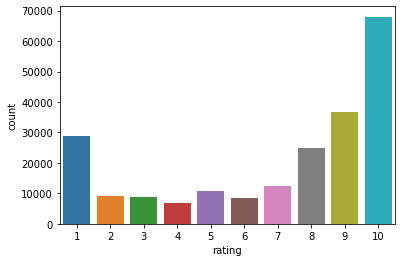

In [15]:
sns.countplot(df['rating'])

In [16]:
# data is skewed, imalanced towards positive ratings

In [17]:
df.rating.value_counts(normalize=True)

10    0.316210
9     0.170685
1     0.134463
8     0.116459
7     0.058341
5     0.049860
2     0.043080
3     0.040537
6     0.039347
4     0.031019
Name: rating, dtype: float64

### 'usefulCount' column

<AxesSubplot:xlabel='usefulCount', ylabel='count'>

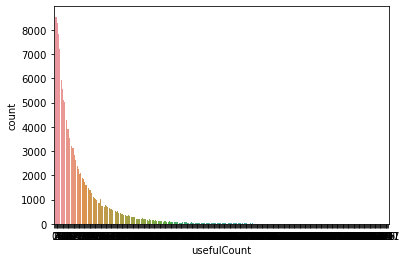

In [18]:
sns.countplot(df['usefulCount'])

<AxesSubplot:xlabel='usefulCount'>

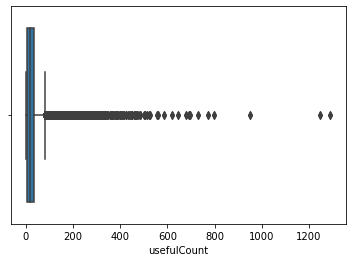

In [19]:
sns.boxplot(x=df['usefulCount'])

In [20]:
df['usefulCount'].describe()

count    215063.000000
mean         28.001004
std          36.346069
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: usefulCount, dtype: float64

In [21]:
df.loc[df['usefulCount'] == 0, 'usefulCount'].count()

8402

In [22]:
df.usefulCount.value_counts()

2      8543
3      8525
0      8402
4      8301
1      8237
       ... 
309       1
337       1
400       1
372       1
288       1
Name: usefulCount, Length: 397, dtype: int64

### General trends in the data

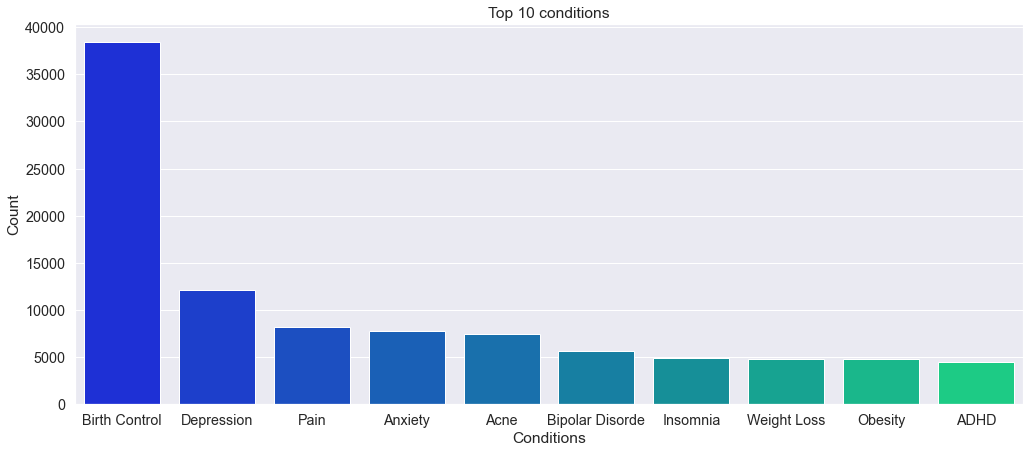

In [23]:
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [17, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

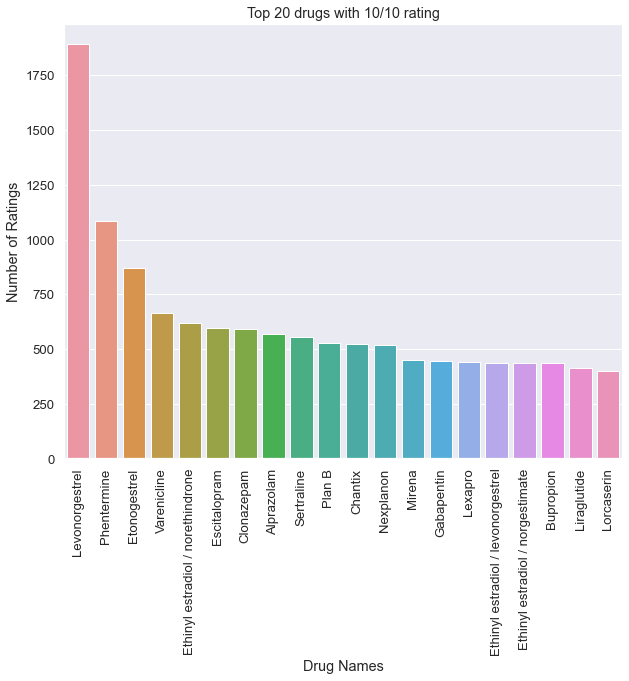

In [24]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

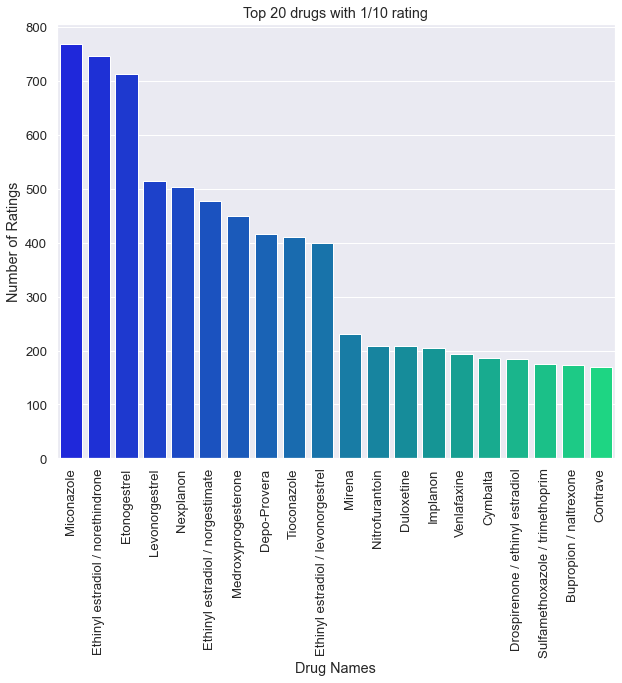

In [25]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

## Data Cleaning

### Clean 'condition' column

In [26]:
df["condition_clean"] = df.condition.apply(lambda x: "unknown" if str(x).__contains__("users found this comment helpful.") else x)

In [27]:
df.loc[df["condition_clean"] == "unknown", "condition_clean"].count() 

1171

In [28]:
df["condition_clean"].apply(lambda x: str(x).lower()).nunique()

838

In [29]:
df.condition_clean.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       nan, 'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'U

In [30]:
df["condition_clean"].nunique()

837

In [31]:
#df = df.dropna()
df
# -1194 records
df.condition.fillna("unknown", axis=0, inplace=True)

### Clean reviews (inplace)

In [32]:
df.drop(["Unnamed: 0","date", "condition"], axis=1, inplace=True)

In [33]:
df["review"] = df.review.str.replace("&#039;", "")
#df

In [34]:
#lower casing
df.review = df.review.str.lower()

# Removing special Characters
#df.review = df.review.str.replace(r'[^\w\d\s]',' ')

# Removing all the non ASCII characters
df.review = df.review.str.replace(r'[^\x00-\x7F]+',' ')

# Removing the leading and trailing Whitespaces
#df.review = df.review.str.replace(r'^\s+|\s+?$','')
    
# Replacing multiple Spaces with Single Space
df.review = df.review.str.replace(r'\s+',' ')
    
# Replacing Two or more dots with one
df.review = df.review.str.replace(r'\.{2,}', ' ')

In [35]:
#df.to_excel("drugs_df.xlsx")

In [36]:
df

,drugName,review,rating,usefulCount,length,condition_clean
0,Valsartan,"""it has no side effect, i take it in combinati...",9,27,17,Left Ventricular Dysfunction
1,Guanfacine,"""my son is halfway through his fourth week of ...",8,192,141,ADHD
2,Lybrel,"""i used to take another oral contraceptive, wh...",5,17,134,Birth Control
3,Ortho Evra,"""this is my first time using any form of birth...",8,10,89,Birth Control
4,Buprenorphine / naloxone,"""suboxone has completely turned my life around...",9,37,124,Opiate Dependence
...,...,...,...,...,...,...
53761,Tamoxifen,"""i have taken tamoxifen for 5 years. side effe...",10,43,97,"Breast Cancer, Prevention"
53762,Escitalopram,"""ive been taking lexapro (escitaploprgram) sin...",9,11,130,Anxiety
53763,Levonorgestrel,"""im married, 34 years old and i have no kids. ...",8,7,149,Birth Control
53764,Tapentadol,"""i was prescribed nucynta for severe neck/shou...",1,20,34,Pain


In [66]:
column_names = ["drugName", "condition_clean", "review", "usefulCount", "length", "rating"]
df_clean = df.reindex(columns=column_names)
df_clean

,drugName,condition_clean,review,usefulCount,length,rating
0,Valsartan,Left Ventricular Dysfunction,"""it has no side effect, i take it in combinati...",27,17,1
1,Guanfacine,ADHD,"""my son is halfway through his fourth week of ...",192,141,1
2,Lybrel,Birth Control,"""i used to take another oral contraceptive, wh...",17,134,0
3,Ortho Evra,Birth Control,"""this is my first time using any form of birth...",10,89,1
4,Buprenorphine / naloxone,Opiate Dependence,"""suboxone has completely turned my life around...",37,124,1
...,...,...,...,...,...,...
53761,Tamoxifen,"Breast Cancer, Prevention","""i have taken tamoxifen for 5 years. side effe...",43,97,1
53762,Escitalopram,Anxiety,"""ive been taking lexapro (escitaploprgram) sin...",11,130,1
53763,Levonorgestrel,Birth Control,"""im married, 34 years old and i have no kids. ...",7,149,1
53764,Tapentadol,Pain,"""i was prescribed nucynta for severe neck/shou...",20,34,0


### Feature engineering: 'rating'

In [37]:
df['rating'] = df.rating.apply(lambda x: 0 if x <= 6 else 1)
df

,drugName,review,rating,usefulCount,length,condition_clean
0,Valsartan,"""it has no side effect, i take it in combinati...",1,27,17,Left Ventricular Dysfunction
1,Guanfacine,"""my son is halfway through his fourth week of ...",1,192,141,ADHD
2,Lybrel,"""i used to take another oral contraceptive, wh...",0,17,134,Birth Control
3,Ortho Evra,"""this is my first time using any form of birth...",1,10,89,Birth Control
4,Buprenorphine / naloxone,"""suboxone has completely turned my life around...",1,37,124,Opiate Dependence
...,...,...,...,...,...,...
53761,Tamoxifen,"""i have taken tamoxifen for 5 years. side effe...",1,43,97,"Breast Cancer, Prevention"
53762,Escitalopram,"""ive been taking lexapro (escitaploprgram) sin...",1,11,130,Anxiety
53763,Levonorgestrel,"""im married, 34 years old and i have no kids. ...",1,7,149,Birth Control
53764,Tapentadol,"""i was prescribed nucynta for severe neck/shou...",0,20,34,Pain


In [38]:
df['rating'].value_counts()

1    142306
0     72757
Name: rating, dtype: int64

In [39]:
column_names = ["drugName", "condition_clean", "review", "usefulCount", "length", "rating"]
df = df.reindex(columns=column_names)
df

,drugName,condition_clean,review,usefulCount,length,rating
0,Valsartan,Left Ventricular Dysfunction,"""it has no side effect, i take it in combinati...",27,17,1
1,Guanfacine,ADHD,"""my son is halfway through his fourth week of ...",192,141,1
2,Lybrel,Birth Control,"""i used to take another oral contraceptive, wh...",17,134,0
3,Ortho Evra,Birth Control,"""this is my first time using any form of birth...",10,89,1
4,Buprenorphine / naloxone,Opiate Dependence,"""suboxone has completely turned my life around...",37,124,1
...,...,...,...,...,...,...
53761,Tamoxifen,"Breast Cancer, Prevention","""i have taken tamoxifen for 5 years. side effe...",43,97,1
53762,Escitalopram,Anxiety,"""ive been taking lexapro (escitaploprgram) sin...",11,130,1
53763,Levonorgestrel,Birth Control,"""im married, 34 years old and i have no kids. ...",7,149,1
53764,Tapentadol,Pain,"""i was prescribed nucynta for severe neck/shou...",20,34,0


## Creating the Corpus

In [40]:
reviews = ['']
corpus=[]
for review in df['review']:
    reviews.append(review)
    corpus.append(nltk.sent_tokenize(review))
corpus

[['"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"'],
 ['"my son is halfway through his fourth week of intuniv.',
  'we became concerned when he began this last week, when he started taking the highest dose he will be on.',
  'for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.)',
  'i called his doctor on monday morning and she said to stick it out a few days.',
  'see how he did at school, and with getting up in the morning.',
  'the last two days have been problem free.',
  'he is much more agreeable than ever.',
  'he is less emotional (a good thing), less cranky.',
  'he is remembering all the things he should.',
  'overall his behavior is better.',
  'we have tried many different medications and so far this is the most effective."'],
 ['"i used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 

In [41]:
len(corpus)

215063

In [42]:
corpus=[sent for sublist in corpus for sent in sublist]
corpus

['"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"',
 '"my son is halfway through his fourth week of intuniv.',
 'we became concerned when he began this last week, when he started taking the highest dose he will be on.',
 'for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.)',
 'i called his doctor on monday morning and she said to stick it out a few days.',
 'see how he did at school, and with getting up in the morning.',
 'the last two days have been problem free.',
 'he is much more agreeable than ever.',
 'he is less emotional (a good thing), less cranky.',
 'he is remembering all the things he should.',
 'overall his behavior is better.',
 'we have tried many different medications and so far this is the most effective."',
 '"i used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other 

In [89]:
len(corpus)

49621

### Cleaning corpus

In [44]:
for i in range(len(corpus)):
    corpus[i] = re.sub(r'\d+','', corpus[i]) # Replace one or more digits by  ' '
    corpus[i] = re.sub(r"\s*'\s*\w*"," ", corpus[i])
    corpus[i] = re.sub(r'\W+',' ',corpus[i]) # Replace everything non-alpahnumeric by ' '
    corpus[i] = re.sub(r'\s+',' ', corpus[i]) # Replace one or more whitespaces by  ' '    
    corpus[i] = re.sub(r'^\s+|\s+?$','', corpus[i])
corpus

['it has no side effect i take it in combination of bystolic mg and fish oil',
 'my son is halfway through his fourth week of intuniv',
 'we became concerned when he began this last week when he started taking the highest dose he will be on',
 'for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him',
 'i called his doctor on monday morning and she said to stick it out a few days',
 'see how he did at school and with getting up in the morning',
 'the last two days have been problem free',
 'he is much more agreeable than ever',
 'he is less emotional a good thing less cranky',
 'he is remembering all the things he should',
 'overall his behavior is better',
 'we have tried many different medications and so far this is the most effective',
 'i used to take another oral contraceptive which had pill cycle and was very happy very light periods max days no other side effects',
 'but it contained hormone

In [121]:
corpus_pre_tok = corpus.copy()
corpus_pre_tok

[(77328, 'day'),
 (71323, 'side'),
 (68293, 'taking'),
 (62580, 'years'),
 (60591, 'pain'),
 (60335, 'effects'),
 (59993, 'first'),
 (58449, 'take'),
 (57402, 'months'),
 (56527, 'started'),
 (56210, 'like'),
 (55121, 'get'),
 (54259, 'days'),
 (51828, 'time'),
 (47466, 'feel'),
 (44357, 'would'),
 (41727, 'back'),
 (41362, 'pill'),
 (40292, 'one'),
 (39944, 'weeks'),
 (38269, 'week'),
 (37469, 'took'),
 (37374, 'also'),
 (37236, 'period'),
 (36951, 'medication'),
 (36742, 'weight'),
 (36711, 'doctor'),
 (36189, 'got'),
 (35417, 'month'),
 (33897, 'life'),
 (33813, 'since'),
 (33790, 'dont'),
 (32733, 'bad'),
 (32562, 'still'),
 (32189, 'anxiety'),
 (31741, 'really'),
 (31214, 'much'),
 (30009, 'never'),
 (29328, 'better'),
 (29180, 'went'),
 (28837, 'medicine'),
 (28751, 'work'),
 (28695, 'two'),
 (28383, 'quot'),
 (27621, 'felt'),
 (27614, 'well'),
 (27213, 'control'),
 (27191, 'every'),
 (26660, 'didnt'),
 (26541, 'good'),
 (26021, 'year'),
 (25759, 'even'),
 (25747, 'great'),
 (254

In [45]:
# Tokenizing the corpus

In [46]:
wordfreq = {}
for sentence in corpus:
    words = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words:
        if ( word not in wordfreq.keys() ): ## first time appearnce in the sentence
            wordfreq[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq[word] += 1 # We increase the corresponding counter

In [47]:
len(list(wordfreq.keys()))

49773

In [48]:
wordfreq

{'it': 384381,
 'has': 64543,
 'no': 80330,
 'side': 71323,
 'effect': 14623,
 'i': 998185,
 'take': 58449,
 'in': 168630,
 'combination': 2158,
 'of': 228762,
 'bystolic': 329,
 'mg': 60764,
 'and': 575215,
 'fish': 199,
 'oil': 888,
 'my': 389314,
 'son': 3069,
 'is': 150286,
 'halfway': 247,
 'through': 12769,
 'his': 4209,
 'fourth': 831,
 'week': 38269,
 'intuniv': 259,
 'we': 10003,
 'became': 5849,
 'concerned': 1258,
 'when': 48801,
 'he': 18186,
 'began': 6811,
 'this': 180956,
 'last': 21329,
 'started': 56527,
 'taking': 68293,
 'the': 542846,
 'highest': 472,
 'dose': 20990,
 'will': 35799,
 'be': 53988,
 'on': 182454,
 'for': 269085,
 'two': 28695,
 'days': 54259,
 'could': 19811,
 'hardly': 1808,
 'get': 55121,
 'out': 51296,
 'bed': 8199,
 'was': 235640,
 'very': 52954,
 'cranky': 233,
 'slept': 2383,
 'nearly': 3165,
 'hours': 21618,
 'a': 385295,
 'drive': 9491,
 'home': 4281,
 'from': 51060,
 'school': 4179,
 'vacation': 364,
 'unusual': 568,
 'him': 3967,
 'called': 

### Reducing the corpus

#### Stopwords

In [49]:
# How to add or exclude words?

from nltk.corpus import stopwords

stop_words = list(stopwords.words('english')) 
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [50]:
for i in range(len(stop_words)):
    stop_words[i] = re.sub(r"\s*'\s*\w*","",stop_words[i])
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'you',
 'you',
 'you',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more'

In [51]:
stop_words.extend(['im', 'ive', 'it', 'mg'])

In [52]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]
corpus

[(71323, 'side'),
 (14623, 'effect'),
 (58449, 'take'),
 (2158, 'combination'),
 (329, 'bystolic'),
 (199, 'fish'),
 (888, 'oil'),
 (3069, 'son'),
 (247, 'halfway'),
 (831, 'fourth'),
 (38269, 'week'),
 (259, 'intuniv'),
 (5849, 'became'),
 (1258, 'concerned'),
 (6811, 'began'),
 (21329, 'last'),
 (56527, 'started'),
 (68293, 'taking'),
 (472, 'highest'),
 (20990, 'dose'),
 (28695, 'two'),
 (54259, 'days'),
 (19811, 'could'),
 (1808, 'hardly'),
 (55121, 'get'),
 (8199, 'bed'),
 (233, 'cranky'),
 (2383, 'slept'),
 (3165, 'nearly'),
 (21618, 'hours'),
 (9491, 'drive'),
 (4281, 'home'),
 (4179, 'school'),
 (364, 'vacation'),
 (568, 'unusual'),
 (3139, 'called'),
 (36711, 'doctor'),
 (1036, 'monday'),
 (13897, 'morning'),
 (10614, 'said'),
 (2390, 'stick'),
 (13471, 'see'),
 (19458, 'getting'),
 (9012, 'problem'),
 (6406, 'free'),
 (31214, 'much'),
 (12, 'agreeable'),
 (17131, 'ever'),
 (11072, 'less'),
 (3979, 'emotional'),
 (26541, 'good'),
 (13417, 'thing'),
 (537, 'remembering'),
 (103

In [53]:
corpus.sort(reverse = True)

# Here we keep only the 20 most frequent words but it can be changed to another bigger value
corpus_freq = [(word[1],word[0]) for word in corpus[:31]] 
corpus_freq = corpus_freq[1:]
corpus_freq


[('side', 71323),
 ('taking', 68293),
 ('years', 62580),
 ('pain', 60591),
 ('effects', 60335),
 ('first', 59993),
 ('take', 58449),
 ('months', 57402),
 ('started', 56527),
 ('like', 56210),
 ('get', 55121),
 ('days', 54259),
 ('time', 51828),
 ('feel', 47466),
 ('would', 44357),
 ('back', 41727),
 ('pill', 41362),
 ('one', 40292),
 ('weeks', 39944),
 ('week', 38269),
 ('took', 37469),
 ('also', 37374),
 ('period', 37236),
 ('medication', 36951),
 ('weight', 36742),
 ('doctor', 36711),
 ('got', 36189),
 ('month', 35417),
 ('life', 33897),
 ('since', 33813)]

In [54]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq]
corpus_freq

[nltk_data] Downloading package omw-1.4 to /Users/odelia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[('side', 71323),
 ('taking', 68293),
 ('year', 62580),
 ('pain', 60591),
 ('effect', 60335),
 ('first', 59993),
 ('take', 58449),
 ('month', 57402),
 ('started', 56527),
 ('like', 56210),
 ('get', 55121),
 ('day', 54259),
 ('time', 51828),
 ('feel', 47466),
 ('would', 44357),
 ('back', 41727),
 ('pill', 41362),
 ('one', 40292),
 ('week', 39944),
 ('week', 38269),
 ('took', 37469),
 ('also', 37374),
 ('period', 37236),
 ('medication', 36951),
 ('weight', 36742),
 ('doctor', 36711),
 ('got', 36189),
 ('month', 35417),
 ('life', 33897),
 ('since', 33813)]

In [55]:
# Updating the df

In [56]:
cols = {word[0]: [] for word in corpus_freq}
reviews = pd.DataFrame(cols)

reviews

,side,taking,year,pain,effect,first,take,month,started,like,...,week,took,also,period,medication,weight,doctor,got,life,since


In [57]:
def review_inpector(sentence, stop_words, words):

    import re

    # Decompose the review in words -> tokens
    tokens = nltk.word_tokenize(sentence)
    # Cleanup the tokenp
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tokens[i] = re.sub(r'\W',' ',tokens[i]) # Replace everything non-alpahnumeric by ' '
        tokens[i] = re.sub(r'\s+','',tokens[i]) # Replace one or more whitespaces by  ' '
        tokens[i] = re.sub(r'\d+','',tokens[i]) # Replace one or more digits by  ' '
        tokens[i] = lem.lemmatize(tokens[i])
        
    # Dropping tokens which are "stopwords" or empty
    tokens = [ token for token in tokens if (token not in stop_words and token != '')]

    # Initializing an empty dictionary of word frequencies for the corresponding review
    col_freq = {col:0 for col in words}
    
    # Filling the dictionary with word frequencies in the review
    for token in tokens:
        if token in words:
            col_freq[token] += 1

    return col_freq

In [58]:
my_list = list(map(review_inpector, df['review'], 
                    [stop_words]*df.shape[0], [list(cols.keys())]*df.shape[0] ) )

my_list[:2]

[{'side': 1,
  'taking': 0,
  'year': 0,
  'pain': 0,
  'effect': 1,
  'first': 0,
  'take': 1,
  'month': 0,
  'started': 0,
  'like': 0,
  'get': 0,
  'day': 0,
  'time': 0,
  'feel': 0,
  'would': 0,
  'back': 0,
  'pill': 0,
  'one': 0,
  'week': 0,
  'took': 0,
  'also': 0,
  'period': 0,
  'medication': 0,
  'weight': 0,
  'doctor': 0,
  'got': 0,
  'life': 0,
  'since': 0},
 {'side': 0,
  'taking': 1,
  'year': 0,
  'pain': 0,
  'effect': 0,
  'first': 0,
  'take': 0,
  'month': 0,
  'started': 1,
  'like': 0,
  'get': 1,
  'day': 3,
  'time': 0,
  'feel': 0,
  'would': 0,
  'back': 0,
  'pill': 0,
  'one': 0,
  'week': 2,
  'took': 0,
  'also': 0,
  'period': 0,
  'medication': 1,
  'weight': 0,
  'doctor': 1,
  'got': 0,
  'life': 0,
  'since': 0}]

In [59]:
reviews = pd.DataFrame(my_list)

In [60]:
reviews

,side,taking,year,pain,effect,first,take,month,started,like,...,week,took,also,period,medication,weight,doctor,got,life,since
0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,2,0,0,0,1,0,1,0,0,0
2,3,1,0,0,2,1,1,0,1,0,...,4,0,0,5,0,0,0,1,0,0
3,0,0,0,0,0,3,0,1,0,0,...,0,0,1,3,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215058,1,1,1,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
215059,0,1,0,0,2,2,1,1,0,4,...,2,1,0,0,0,0,0,0,1,1
215060,0,2,2,0,0,1,1,1,1,0,...,1,0,0,1,0,0,0,1,0,0
215061,0,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
reviews['rating'] = df['rating'].reset_index(drop=True)
reviews

,side,taking,year,pain,effect,first,take,month,started,like,...,took,also,period,medication,weight,doctor,got,life,since,rating
0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
2,3,1,0,0,2,1,1,0,1,0,...,0,0,5,0,0,0,1,0,0,0
3,0,0,0,0,0,3,0,1,0,0,...,0,1,3,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215058,1,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
215059,0,1,0,0,2,2,1,1,0,4,...,1,0,0,0,0,0,0,1,1,1
215060,0,2,2,0,0,1,1,1,1,0,...,0,0,1,0,0,0,1,0,0,1
215061,0,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Running the Models

In [62]:
X = reviews.drop(columns='rating')
y = reviews['rating']
X
y

0         1
1         1
2         0
3         1
4         1
         ..
215058    1
215059    1
215060    1
215061    0
215062    1
Name: rating, Length: 215063, dtype: int64

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

y_train = pd.DataFrame(y_train, columns =['rating'])
y_test  = pd.DataFrame(y_test, columns =['rating'])

In [64]:
X_train
y_train

,rating
188965,0
15538,1
204522,1
110705,1
156549,1
...,...
119879,1
103694,1
131932,0
146867,1


### Calculating P of rating using Bayes 

def bayes(df, rating, review): # rating = stars, review = X; P(R|X)
    df2 = df.copy()
    p_rating = len(df2[df2['rating'] == rating]) / len(df2)
    m = ((df2.iloc[:,:-1] == review).apply(sum, axis=1)).tolist()
    t = [index for index, value in enumerate(m) if value == 50]
    p_review = len(t) / len(df2)
    temp = df2[df2['rating'] == rating]
    m = ((df2[df2['rating'] == rating].iloc[:,:-1] == review).apply(sum, axis=1)).tolist()
    t = [index for index, value in enumerate(m) if value == 50]
    p_rating_review = len(t) / len(temp)
    p = ( p_rating * p_rating_review ) / p_review
    return round(p,2)

Using a list comprehension to compute the probability of a given review to have a given rating
prob = [bayes(reviews, i, reviews.iloc[0,:-1].tolist()) for i in ['0','1']]
Normalizing the probabilities
partition = np.sum(prob)
#partition
prob = [ ('Probability rating = ' + str(index+1),round(p/partition,2)) for index, p in enumerate(prob) ]
prob   

In [ ]:
#reviews.iloc[0,-1]

In [ ]:
#y_train_res.shape

In [65]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier

nb = CategoricalNB()
rf = RandomForestClassifier()

nb.fit(X_train, y_train['rating'])
rf.fit(X_train, y_train['rating'])

RandomForestClassifier()

#### Making predictions

In [82]:
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)

In [83]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

In [85]:
model_performance_class(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.81
              precision    recall  f1-score   support

           0       0.95      0.80      0.87     50803
           1       0.91      0.98      0.94     99741

    accuracy                           0.92    150544
   macro avg       0.93      0.89      0.90    150544
weighted avg       0.92      0.92      0.92    150544

Results obtained for the TEST SET
The Cohen's Kappa is: 0.52
              precision    recall  f1-score   support

           0       0.79      0.56      0.65     21954
           1       0.80      0.92      0.86     42565

    accuracy                           0.80     64519
   macro avg       0.79      0.74      0.75     64519
weighted avg       0.80      0.80      0.79     64519



## TF-IDF (Term-Frequency Inverse Document-Frequency)

### Dataset prep: re-cleaning reviews

In [90]:
# Using Rafa's nice function from now on

def clean_review(x):
    x = str(x).lower().replace("\\","").replace("_"," ")
    x = re.sub(r'\W+',' ',x) # Replace everything non-alpahnumeric by ' '
    x = re.sub(r'\s+',' ',x) # Replace one or more whitespaces by  ' '
    x = re.sub(r'\d+',' ',x) # Replace one or more digits by  ' '
    x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", x) # Replace e-mails by ''
    # Replace urls by ''
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , x) 
    # Replace html tags by ''
    x = BeautifulSoup(x, 'html.parser').get_text().strip()
    x = x.replace(' br ',' ')

    return x

In [93]:
reviews_cleaned = df.copy()

In [94]:
reviews_cleaned = reviews_cleaned[['review','rating']]

In [100]:
reviews_cleaned.head()

,review,rating
0,it has no side effect i take it in combination...,1
1,my son is halfway through his fourth week of i...,1
2,i used to take another oral contraceptive whic...,0
3,this is my first time using any form of birth ...,1
4,suboxone has completely turned my life around ...,1


In [109]:
reviews_cleaned['review'] = reviews_cleaned['review'].apply(lambda x: clean_review(x)) 

In [101]:
reviews_cleaned.head()

,review,rating
0,it has no side effect i take it in combination...,1
1,my son is halfway through his fourth week of i...,1
2,i used to take another oral contraceptive whic...,0
3,this is my first time using any form of birth ...,1
4,suboxone has completely turned my life around ...,1


### Running the TF-IDF model 
* bi-grams

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

tidf = TfidfVectorizer(max_features = 20000, ngram_range = (2,2), analyzer = 'word',
                       stop_words = stop_words )

In [108]:
X_TF = tidf.fit_transform(reviews_cleaned['review'])
y_TF = reviews_cleaned['rating']

In [104]:
tidf.get_feature_names()

['abdominal cramping',
 'abdominal cramps',
 'abdominal discomfort',
 'abdominal pain',
 'abdominal pains',
 'ability focus',
 'ability function',
 'able afford',
 'able breath',
 'able breathe',
 'able complete',
 'able concentrate',
 'able continue',
 'able control',
 'able cope',
 'able cut',
 'able deal',
 'able drink',
 'able drive',
 'able eat',
 'able enjoy',
 'able fall',
 'able feel',
 'able find',
 'able focus',
 'able function',
 'able get',
 'able go',
 'able handle',
 'able hold',
 'able keep',
 'able leave',
 'able live',
 'able lose',
 'able maintain',
 'able make',
 'able manage',
 'able move',
 'able perform',
 'able put',
 'able quit',
 'able return',
 'able see',
 'able sex',
 'able sit',
 'able sleep',
 'able stand',
 'able start',
 'able stay',
 'able stop',
 'able take',
 'able talk',
 'able tell',
 'able things',
 'able think',
 'able tolerate',
 'able use',
 'able walk',
 'able wear',
 'able work',
 'abnormal bleeding',
 'absolute best',
 'absolute hell',
 'abso

In [105]:
len(tidf.get_feature_names())

20000

In [106]:
X_TF[:2,:5]

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

#### Train test split

In [111]:
X_TF_train, X_TF_test, y_TF_train, y_TF_test = train_test_split(X_TF, y_TF, test_size=0.30, random_state=42)

In [112]:
type(X_TF_train)

scipy.sparse.csr.csr_matrix

#### Generating the model

In [113]:
from sklearn.ensemble import RandomForestClassifier

# We can go with lots of features because our dataset contains 20K!!!
rf = RandomForestClassifier(max_depth=100, n_estimators=50)

y_TF_train = y_TF_train.astype('int')
y_TF_test  = y_TF_test.astype('int')

rf.fit(X_TF_train, y_TF_train)

y_TF_train_pred_rf = rf.predict(X_TF_train)
y_TF_test_pred_rf  = rf.predict(X_TF_test)

In [114]:
model_performance_class(y_TF_train, y_TF_train_pred_rf, y_TF_test, y_TF_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.47
              precision    recall  f1-score   support

           0       0.99      0.40      0.57     50803
           1       0.77      1.00      0.87     99741

    accuracy                           0.80    150544
   macro avg       0.88      0.70      0.72    150544
weighted avg       0.84      0.80      0.77    150544

Results obtained for the TEST SET
The Cohen's Kappa is: 0.35
              precision    recall  f1-score   support

           0       0.90      0.32      0.47     21954
           1       0.74      0.98      0.84     42565

    accuracy                           0.75     64519
   macro avg       0.82      0.65      0.65     64519
weighted avg       0.79      0.75      0.71     64519



In [116]:
# use nltk.tagger to tag each word
# keep only nouns and adjectives

In [115]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [118]:
def filter_review(x):
    text = word_tokenize(x)
    # Apply an steemer
    tags = nltk.pos_tag(text)
    words = []
    for tag in tags:
        # Include the type of words that you want to consider.
        # It will be also better 
        if ( tag[1] in ['JJ','NN','VB'] ):
            words.extend(tag[0])
    return " ".join(words)

In [119]:
corpus

[(77328, 'day'),
 (71323, 'side'),
 (68293, 'taking'),
 (62580, 'years'),
 (60591, 'pain'),
 (60335, 'effects'),
 (59993, 'first'),
 (58449, 'take'),
 (57402, 'months'),
 (56527, 'started'),
 (56210, 'like'),
 (55121, 'get'),
 (54259, 'days'),
 (51828, 'time'),
 (47466, 'feel'),
 (44357, 'would'),
 (41727, 'back'),
 (41362, 'pill'),
 (40292, 'one'),
 (39944, 'weeks'),
 (38269, 'week'),
 (37469, 'took'),
 (37374, 'also'),
 (37236, 'period'),
 (36951, 'medication'),
 (36742, 'weight'),
 (36711, 'doctor'),
 (36189, 'got'),
 (35417, 'month'),
 (33897, 'life'),
 (33813, 'since'),
 (33790, 'dont'),
 (32733, 'bad'),
 (32562, 'still'),
 (32189, 'anxiety'),
 (31741, 'really'),
 (31214, 'much'),
 (30009, 'never'),
 (29328, 'better'),
 (29180, 'went'),
 (28837, 'medicine'),
 (28751, 'work'),
 (28695, 'two'),
 (28383, 'quot'),
 (27621, 'felt'),
 (27614, 'well'),
 (27213, 'control'),
 (27191, 'every'),
 (26660, 'didnt'),
 (26541, 'good'),
 (26021, 'year'),
 (25759, 'even'),
 (25747, 'great'),
 (254

In [122]:
filter_review(corpus_pre_tok)

TypeError: expected string or bytes-like object

## Running a linear regression on non-textual variables

In [110]:
df_clean.drop(['review'], axis=1, inplace=True)
df_clean

AttributeError: 'NoneType' object has no attribute 'drop'

In [75]:
## save excel here 

### X/y split

### Train/test split

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=123)

### Standartization

In [ ]:
std_scaler = StandardScaler().fit(X_train) 

X_train_scaled = std_scaler.transform(X_train)

In [ ]:
X_test_scaled=std_scaler.transform(X_test)

In [ ]:
print(X_train_scaled)
print("--------")
print(X_test_scaled)

### Running the regression

In [ ]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)